# SageMaker Pipelines - Starting multi-tenant Pipelines (SaaS)

This notebook demonstrates starting SageMaker Pipelines in a software as a service (SaaS) model.

Here we will start tenant specific pipelines which we created in the previous **[00-DemoCreateTenantPipelines.ipynb](./00-DemoCreateTenantPipelines.ipynb)** notebook with tenant isolation implemented using [ABAC](https://docs.aws.amazon.com/IAM/latest/UserGuide/tutorial_attribute-based-access-control.html) role. This is accomplished using the name of the Pipeline(s). 

This notebook has been tested on SageMaker Studio using the `Data Science` kernel on an `ml.t3.medium`. 


Please make sure your execution role attached to your Studio user profile has `iam:CreatePolicy, iam:CreateRole, iam:AttachRolePolicy and SageMakerFullAccess` permissions/policy attached.

---

### Create ABAC role for starting tenant pipelines
In this section we create an IAM role (`DemoStartPipelineRole`) and policy which only allows a tenant to only start their specific Pipeline.

First we create a policy for the role that restricts starting to a Pipeline which is taged with the specific tenant (`aws:PrincipalTag/TenantID`). `aws:PrincipalTag/TenantID` will match the principal thats making the API call. I.e. when tenant1 makes StartPipeline API call  `aws:PrincipalTag/TenantID` will be of the value `tenant1` 

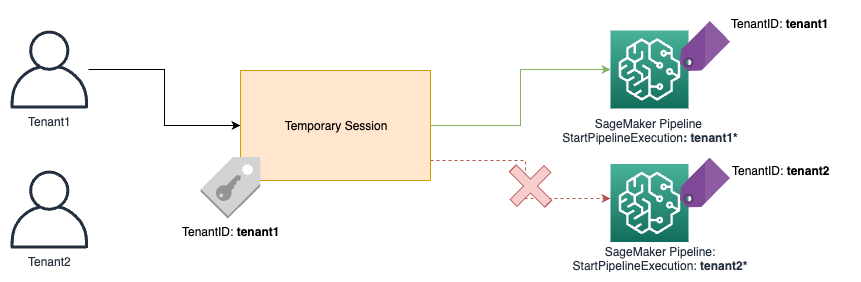

In order to conform with the policy above we will need to assume the `DemoStartPipelineRole` and provide the session TenantID tag corresponding to the specific tenant. 

For this example, we are using the SageMaker Studo execution role to Assume `DemoStartPipelineRole`.  

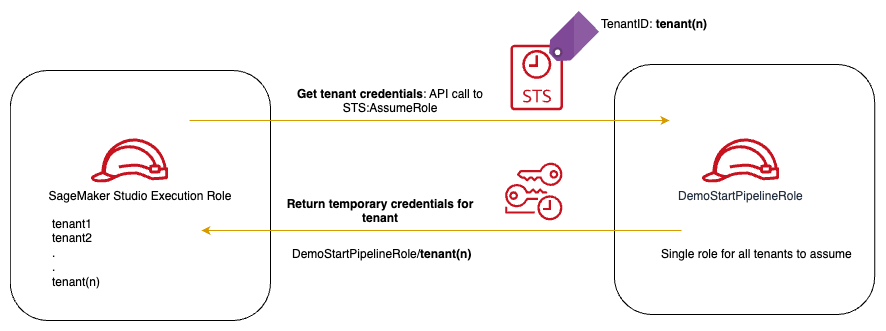

In [38]:
import boto3
import json
import sagemaker.session

sts = boto3.client('sts')
iam = boto3.client('iam')
region = boto3.session.Session().region_name
account_id = sts.get_caller_identity()['Account']

sagemaker_exec_role=sagemaker.session.get_execution_role().split('/')[-1]

start_pipeline_policy_name="DemoStartPipelineExecutionPolicy"

start_pipeline_policy_document = {
    "Version": "2012-10-17",
    "Statement": [
        {
            "Effect": "Allow",
            "Action": "sagemaker:StartPipelineExecution",
            "Resource": f"arn:aws:sagemaker:{region}:{account_id}:pipeline/${{aws:PrincipalTag/TenantID}}-*",
            "Condition": {
                "StringEquals": {
                    "aws:ResourceTag/TenantID": "${aws:PrincipalTag/TenantID}"
                }
            }
        }
    ]
}
try:
    start_pipeline_policy = iam.create_policy(
        PolicyName=start_pipeline_policy_name,
        PolicyDocument=json.dumps(start_pipeline_policy_document)
)

except iam.exceptions.EntityAlreadyExistsException:
    # If the policy already exists, get its ARN
    policy = iam.get_policy(PolicyArn=f"arn:aws:iam::{account_id}:policy/{start_pipeline_policy_name}")

    # Print the ARN of the existing IAM policy
    print(f"The IAM policy {start_pipeline_policy_name} already exists with ARN {policy['Policy']['Arn']}")


The IAM policy DemoStartPipelineExecutionPolicy already exists with ARN arn:aws:iam::171503325295:policy/DemoStartPipelineExecutionPolicy



Now that the policy is created we need to create the role. In the trust policy we will only allow the SageMaker Studio execution role to assume and make sure tags have to be provided when assuming.


In [39]:
start_pipeline_role_policy_document = {
    "Version": "2012-10-17",
    "Statement": [
        {
            "Effect": "Allow",
            "Principal": {
                "AWS": f"arn:aws:sts::{account_id}:assumed-role/{sagemaker_exec_role}/SageMaker"
            },
            "Action": ["sts:AssumeRole","sts:TagSession"],
            "Condition": {
                "StringLike": {
                    "aws:RequestTag/TenantID": "tenant*"
                }
            }
        }
    ]
}

start_pipeline_role_name = "DemoStartPipelineRole"
try:
    start_pipeline_role=iam.create_role(
        RoleName=start_pipeline_role_name,
        AssumeRolePolicyDocument=json.dumps(start_pipeline_role_policy_document)
    )

    iam.attach_role_policy(
        RoleName=start_pipeline_role_name,
        PolicyArn=f"arn:aws:iam::{account_id}:policy/{start_pipeline_policy_name}"
    )
except iam.exceptions.EntityAlreadyExistsException:
    start_pipeline_role = iam.get_role(RoleName=start_pipeline_role_name)
    print(f"The IAM role {start_pipeline_role_name} already exists with ARN {start_pipeline_role['Role']['Arn']}")
    
print(start_pipeline_role_name)


The IAM role DemoStartPipelineRole already exists with ARN arn:aws:iam::171503325295:role/DemoStartPipelineRole
DemoStartPipelineRole


The previous **[00-DemoCreateTenantPipelines.ipynb](./00-DemoCreateTenantPipelines.ipynb)**  notebook has created these pipelines `tenant1-app1, tenant1-app2, tenant2-app1, tenant2-app2`.  In order to start a tenant specific pipeline we need to provide pipeline name, for that please update `tenant_id` and `app_id` variables in the below code. we construct pipeline name  from these variables in the following way `f"{tenant_id}-{app_id}"` 

For a given tenant, if you provide one of tenants pipeline name you will be able to start the tenants pipeline successsfully. But if you provide a pipeline name of a different tenant you will get AccessDeniedException.

In [40]:
import boto3
import sagemaker
from scripts import utils
from sagemaker.s3 import S3Uploader
sagemaker_session = sagemaker.Session()
bucket_name=sagemaker_session.default_bucket()

### Pipeline Parameters
Here we sepcify the Pipeline Parameters. `CheckpointS3Path` will be used to store the model artifacts. 

In [46]:
def start_pipeline(tenant_id, app_id, bucket_name, temp_session):
    tenant_id=tenant_id
    processing_instance_type="ml.m5.xlarge"
    processing_instance_count=1
    training_instance_type="ml.p4d.24xlarge" 
    #training_instance_type="ml.g5.48xlarge" 
    processing_instance_count=1
    training_instance_count=2
    model_version=0
    app_id=app_id

    pipeline_name=f"{tenant_id}-{app_id}-flan"


    #Upload to S3

    s3_uri = f"s3://{bucket_name}/sample-data/{tenant_id}/{app_id}"
    file_path= "sample-data/"
    # Upload the file to the specified S3 bucket
    S3Uploader.upload(file_path, s3_uri)

    # Set up the SageMaker client
    sagemaker_client = temp_session.client('sagemaker')

    response = sagemaker_client.start_pipeline_execution(
                 PipelineName = pipeline_name,
                 PipelineParameters=[
                 {
                     'Name': 'TrainDataPath',
                     'Value': 'train.csv'
                 },
                 {
                     'Name': 'ValidationDataPath',
                     'Value': 'val.csv'

                 },
                 {
                     'Name': 'TenantID',
                     'Value': "{}".format(tenant_id)
                 },         
                 {
                     'Name': 'TenantTier',
                     'Value': "Bronze"
                 },
                 {
                     'Name': 'ModelVersion',
                     'Value': "{}".format(model_version)
                 },
                {
                     'Name': 'AppID',
                     'Value': "{}".format(app_id)
                 },
                 {
                     'Name': 'TrainingInstanceType',
                     'Value': "{}".format(training_instance_type)
                 },
                       {
                     'Name': 'TrainingInstanceCount',
                     'Value': "{}".format(training_instance_count)
                 },

                       {
                     'Name': 'ProcessingInstanceType',
                     'Value': "{}".format(processing_instance_type)
                 },
                        {
                     'Name': 'ProcessingInstanceCount',
                     'Value': "{}".format(processing_instance_count)
                 },
                      {
                     'Name': 'CheckpointS3Path',
                     'Value': "s3://{}/flan-checkpoints/{}/{}/".format(bucket_name,tenant_id,app_id)
                 }
             ]   
         )    

### Start tenant's SageMaker Pipeline

#### Create temp session for tenant1

In [47]:
import time 
wait_time=15
print("Waiting for {} seconds for role creation to propagate ...".format(wait_time))

# Wait for the specified number of seconds
time.sleep(wait_time)

print("Finished waiting!")

Waiting for 15 seconds for role creation to propagate ...
Finished waiting!


In [48]:
access_role=start_pipeline_role['Role']['Arn']
temp_session = utils.create_temp_session(access_role, "tenant1", 900)

Assumed role ARN: arn:aws:sts::171503325295:assumed-role/DemoStartPipelineRole/tenant1


#### Start tenant1 Pipeline

In [49]:
start_pipeline("tenant1", "app1", bucket_name, temp_session)

#### Confirm tenant1 cant run tenant2's pipeline 

In [50]:
start_pipeline("tenant2", "app1", bucket_name, temp_session)

ClientError: An error occurred (AccessDeniedException) when calling the StartPipelineExecution operation: User: arn:aws:sts::171503325295:assumed-role/DemoStartPipelineRole/tenant1 is not authorized to perform: sagemaker:StartPipelineExecution on resource: arn:aws:sagemaker:us-east-1:171503325295:pipeline/tenant2-app1-flan because no identity-based policy allows the sagemaker:StartPipelineExecution action

#### Now that we have started pipelines, please wait for pipelines execution to complete and then move onto Inference . See [02-DemoTenantPipelinesInference.ipynb](./02-DemoTenantPipelinesInference.ipynb)